# Computer vision for animal detection, from first principles

In [95]:
import numpy as np
import pandas as pd
from pathlib import Path

# image manipulation
import skimage.io
import skimage.color
import skimage.filters
import skimage.measure

# geospatial
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.transform import from_origin

# progress bars
import tqdm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# An aerial census of a West African seabird colony (Kellenberger et al., 2021)

our dataset is a high-resolution aerial RGB image collected from a UAV in West Africa in 2019.
- An [orthomosaic](https://en.wikipedia.org/wiki/Orthophoto) image (think Google Earth) containing breeding colonies of terns, gulls, cormorants, pelicans, and more
- RGB GeoTIFF format with a ground resolution of ~1 cm
- of course, it is accompanied by a `.csv` file containing position (point coordinates) and labels (species) of all birds, to use for training purposes.

I discovered this dataset using the incredible [Labeled Information Library of Alexandria](https://lila.science/datasets/aerial-seabirds-west-africa/) resource; the manuscript from which it was derived is:

> Kellenberger B, Veen T, Folmer E, Tuia D. [21,000 birds in 4.5 h: efficient large‐scale seabird detection with machine learning](https://zslpublications.onlinelibrary.wiley.com/doi/10.1002/rse2.200). Remote Sensing in Ecology and Conservation. 2021.

their data is released under the CDLA-Permissive-1.0 license, which means it's fair game for us to use!

The original paper used 6 UAV-captured orthomosaics in total (5 for training, and 1 for testing). We only have access to 1 (the test image), but for our purposes, it should be more than sufficient.

## Loading the image

first, let's read everything into Python and inspect it.

In [204]:
impath = 'data/seabirds_rgb.tif'
im = skimage.io.imread(impath)
im.shape

(28814, 27569, 3)

Looks like we have an approximately 28,000 x 28,000 pixel image, with 3 color channels as expected. 

> Note: the `shape` of a numpy array is rows x columns, so in terms of more familiar xy coordinates, the image's dimensions are flipped: 27,569 x 28,814 pixels.

Cool -- although that's pretty big! We'll likely want to split it into smaller slices that are easier to work with.

In the paper:

> "For the test orthomosaic 1, we created a complete set of annotations for every individual bird we could detect (Fig. 3). To do so, we first divided the orthomosaic into 274 non-overlapping tiles of 800 × 600 pixels, organized on a regular grid. We then created point annotations with class labels in all image tiles using the open source software AIDE5 (Kellenberger et al., 2020), which allows users to annotate images through a web interface..."

## Adding ground-truth labels

How about the bird location data?

The paper uses `labels_birds_paper.csv`, and excludes all labels for which `unsure` == `NaN` (somewhat confusingly, we want those entries for which `unsure` == `True`); this yields 21,066 bird labels in orthomosaic 1.

However, it is not clear what criteria were used to exclude birds from the training set, compared to the contents of `labels_birds_full.csv`. My guess is that the filtering had something to do with _species-level_ labelling, since differentiating seabird species was a key goal of their work. Since all we want to do is distinguish birds from non-bird background, I think we can safely ignore this.

In [205]:
labpath = 'data/labels_birds_full.csv'
lab = pd.read_csv(labpath, index_col=0)

print(lab.shape)
lab.head()

(21516, 4)


,label,unsure,X,Y
1,Royal tern,NaN,53.467212,128.15313
2,Caspian tern,True,160.008336,142.49705
3,Caspian tern,True,160.152381,141.11832
4,(unknown),True,155.500589,136.10456
5,(unknown),True,154.320165,134.96754


There are tens of thousands of labeled birds in this image! How many are [not] "unsure"?

In [206]:
mask = lab['unsure'] == True
lab[mask]

,label,unsure,X,Y
2,Caspian tern,True,160.008336,142.497050
3,Caspian tern,True,160.152381,141.118320
4,(unknown),True,155.500589,136.104560
5,(unknown),True,154.320165,134.967540
6,(unknown),True,156.950081,134.602990
...,...,...,...,...
21434,Gray headed gull,True,111.328131,149.771269
21444,Gray headed gull,True,170.539354,139.334751
21448,Gray headed gull,True,170.539354,139.334751
21450,Gray headed gull,True,87.295366,148.891967


Weirdly, there a few rows with NaNs for X/Y coordinates:

In [207]:
lab_nas = lab[lab['X'].isna() | lab['Y'].isna()]
lab_nas

,label,unsure,X,Y
2337,Royal tern,True,NaN,NaN
5811,Royal tern,True,NaN,NaN
5818,Royal tern,True,NaN,NaN
17080,Royal tern,True,NaN,NaN
17082,Royal tern,True,NaN,NaN


Let's automatically exclude them:

In [208]:
print('Indices of rows to remove:')

for idx in lab_nas.index:
    print(idx)

# do the drop
lab = lab.drop(lab_nas.index)
lab = lab.reset_index(drop=True)
lab

Indices of rows to remove:
2337
5811
5818
17080
17082


,label,unsure,X,Y
0,Royal tern,NaN,53.467212,128.153130
1,Caspian tern,True,160.008336,142.497050
2,Caspian tern,True,160.152381,141.118320
3,(unknown),True,155.500589,136.104560
4,(unknown),True,154.320165,134.967540
...,...,...,...,...
21506,Royal tern,NaN,47.240482,105.169779
21507,Royal tern,NaN,37.676534,104.668118
21508,Royal tern,NaN,47.240482,105.169779
21509,Royal tern,NaN,37.676534,104.668118


Cool; let's just use the whole dataset for now, ignoring the `unsure` column.

### Changing coordinate systems

Now, let's make sure we can accurately use the coordinate information to label the corresponding objects in the image.

Note that the label coordinates are _not_ pixel positions. According to the data source, the coordinate reference system is WGS 84/ UTM zone 28N, i.e. part of the [Universal Transverse Mercator](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system) projection. (Additionally, the origin has been translated to (0,0) to avoid revealing the precise location of the breeding site -- but all internal spatial relationships are preserved.) So, how do we convert these into pixels?

We can use a special library called `rasterio` that's built to work with raster (i.e. image) geospatial data. As we'll see, it comes with some useful functions for coordinate transformations:

In [209]:
src = rasterio.open(impath)

print('CRS is:', src.crs)
print('Bounds are:', src.bounds)
print('Transform is:', src.transform)
print('Image size is:', (src.width, src.height))
print(src.count)
print('Check the origin:', src.transform * (0,0))

CRS is: EPSG:32628
Bounds are: BoundingBox(left=0.0, bottom=0.0, right=292.482, top=305.691)
Transform is: | 0.01, 0.00, 0.00|
| 0.00,-0.01, 305.69|
| 0.00, 0.00, 1.00|
Image size is: (27569, 28814)
3
Check the origin: (0.0, 305.691)


Strangely, it looks like there is a systematic mix-up happening here: the output of that last line should be (0,0) or the top left, not (0, 305.691) or the bottom left...

In other words, what I assume to be X and Y coordinates are actually flipped. Is this a mistake on my part in the processing, or something silly about the (transformed) data in the file? Not sure.

**Note**: see [this discussion](https://scikit-image.org/docs/stable/user_guide/numpy_images.html#coordinate-conventions) of coordinate conventions in scikit-image/array representations of images, compared to Cartesian coordinates.

In [210]:
test = []
for x,y in zip(lab.X, lab.Y):
    test.append(src.index(x,y))

In [211]:
# correct the x/y flip
lab['X_px'] = [x[1] for x in test]
lab['Y_px'] = [x[0] for x in test]

lab

,label,unsure,X,Y,X_px,Y_px
0,Royal tern,NaN,53.467212,128.153130,5039,16734
1,Caspian tern,True,160.008336,142.497050,15082,15382
2,Caspian tern,True,160.152381,141.118320,15095,15512
3,(unknown),True,155.500589,136.104560,14657,15984
4,(unknown),True,154.320165,134.967540,14546,16092
...,...,...,...,...,...,...
21506,Royal tern,NaN,47.240482,105.169779,4452,18900
21507,Royal tern,NaN,37.676534,104.668118,3551,18948
21508,Royal tern,NaN,47.240482,105.169779,4452,18900
21509,Royal tern,NaN,37.676534,104.668118,3551,18948


Let's see how well these pixel coordinates line up with the birds in the image! (Again, this is a big image, so plotting everything might take a little while.)

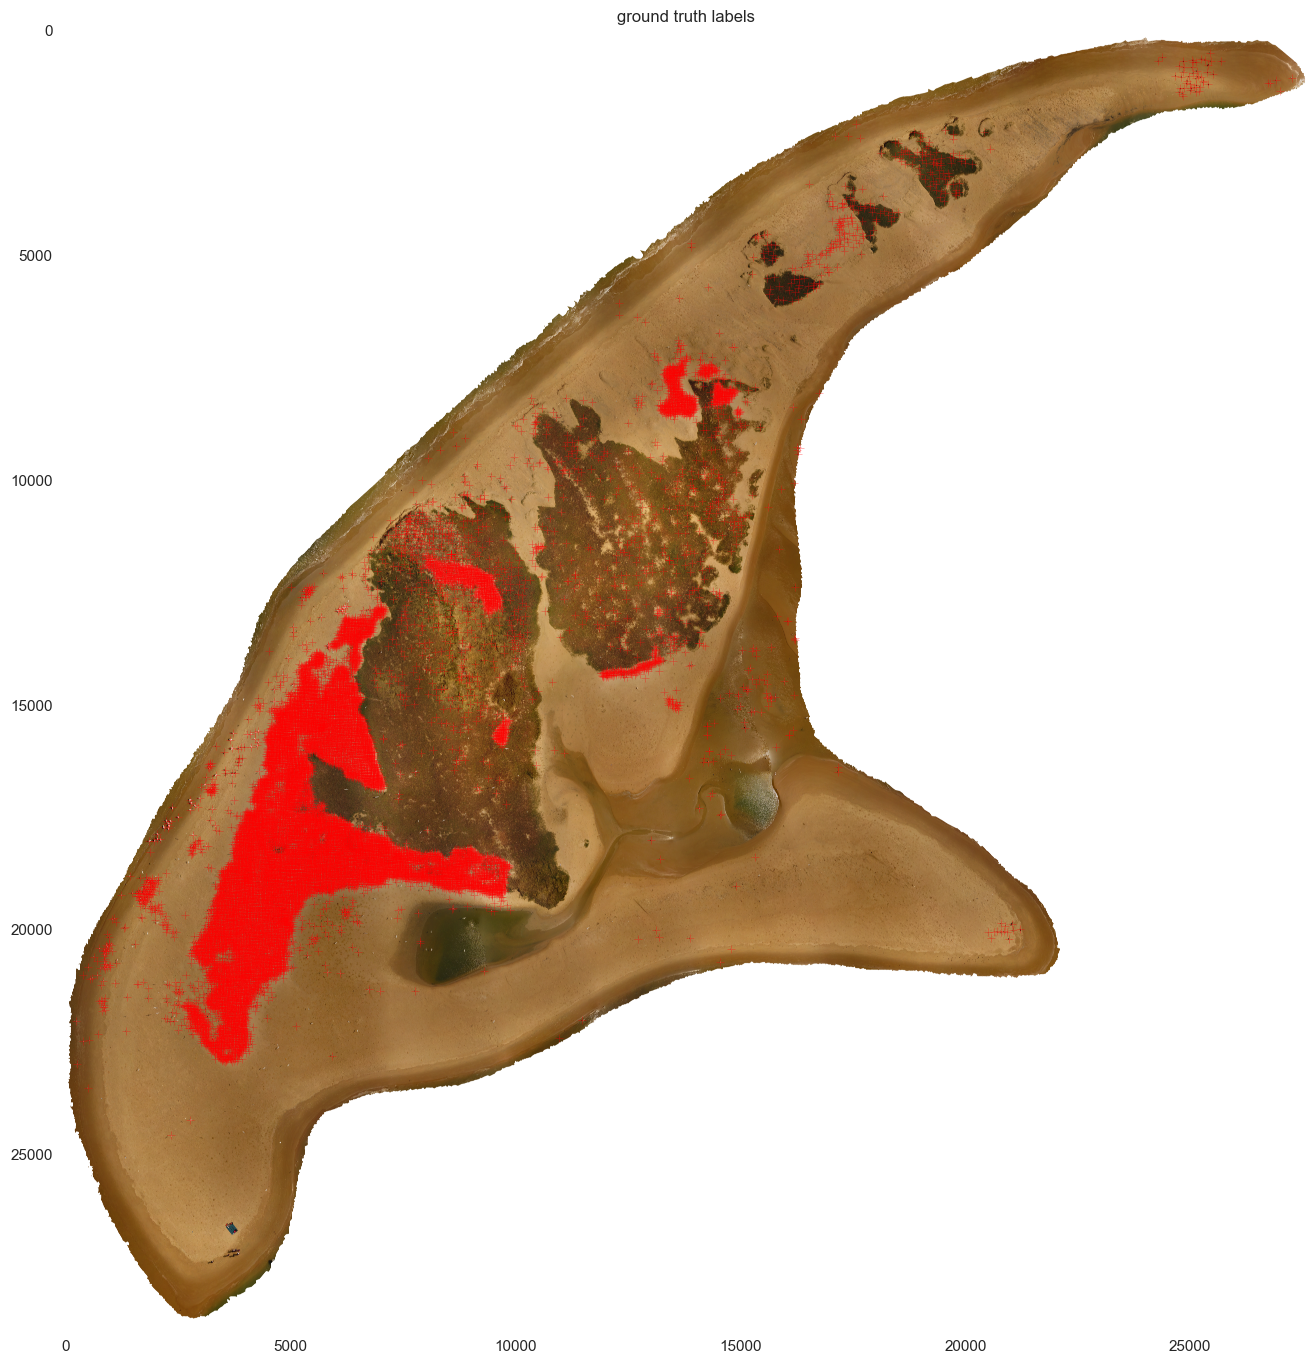

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 20))

xs = lab['X_px']
ys = lab['Y_px']

ax.imshow(im)
ax.plot(xs, ys, linewidth=0, marker='+', markerfacecolor='none', markeredgecolor='red', markersize=6, markeredgewidth=0.5, alpha=0.4)

ax.set_title('ground truth labels')
ax.grid(False)

Great! That looks right.

## Dividing the scene into tiles

As we've already discussed, the authors divided this image "into 274 non-overlapping tiles of 800 x 600 pixels, organized on a regular grid." We'll do something similar.

Here's the plan: I like squares, so let's try making 256 x 256 px tiles. Because a good portion of the scene is unfilled (i.e. white), we will then discard any tiles that lack information. From this subset, we'll use the ground-truth labels to organize our tiles based on how many birds they contain. Finally, we'll do some manual sorting to separate those with "easy" backgrounds (like plain sand) from more difficult ones (like the vegetation at the center of the island).

To accomplish the tiling, I've poached some code from [this GIS StackExchange answer](https://gis.stackexchange.com/questions/285499/how-to-split-multiband-image-into-image-tiles-using-rasterio):

In [355]:
from itertools import product

def get_tiles(ds, width, height):
    '''Helper function: generate non-overlapping tiles from a rasterio dataset.'''
    cols, rows = ds.meta['width'], ds.meta['height']
    offsets = product(range(0, cols, width), range(0, rows, height))
    big_window = rasterio.windows.Window(col_off=0, row_off=0, width=cols, height=rows)

    for col_off, row_off in offsets:
        window = rasterio.windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = rasterio.windows.transform(window, ds.transform)
        yield window, transform

def make_tiles(impath, width=1028, height=1028, dryrun=True):
    '''Split an image into non-overlapping tiles of specified dimensions.
    
    If dryrun, just calculate the coordinates of each tile (without actually producing the images).'''

    tiles = {}
    
    with rasterio.open(impath) as dataset:
        meta = dataset.meta.copy()
        for window, transform in get_tiles(dataset, width, height):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height

            # write tile info to dict
            name = f'tile_{window.col_off}-{window.row_off}'
            tiles[name] = {'width':window.width,
                           'height':window.height,
                           'path':f'data/seabirds_split/{name}.tif',
                           'birds':[]}
            
            
            # produce the images
            if dryrun is False:
                outpath = f'data/seabirds_split/{name}.tif'
                with rasterio.open(outpath, 'w', **meta) as out:
                    out.write(dataset.read(window=window))

        print('Generated', len(tiles), 'tiles')
        return tiles

make_tiles(impath);

Generated 783 tiles


Using a 256 x 256 tile size generates 12,204 squares. Many of these are largely, or only, white background. Only a subset contain birds. And they differ in the complexity of their terrain. (There is also the issue that some birds may have landed at the borders of a tile, i.e. cut in half; we'll need to figure out how to handle this.)

Because working with so many images directly will take some time, let's try to plan ahead as best as possible by just referencing the coordinates involved.

In [213]:
# make_tiles(impath, dryrun=False);

### Linking labels and tiles

For instance, if we know which regions are occupied by each tile (from the filename), we can count how many bird labels are in each one.

In [426]:
def populate_tiles(tiles, lab):
    '''Given tiles and a label df, (1) adds a column specifying tile for each label, and
    (2) returns a dict of all birds associated with each tile.'''
    
    # add empty columns
    lab['tile'] = None
    lab['X_tile'] = None
    lab['Y_tile'] = None
    
    for k,v in tiles.items():

        birds = []

        # get origin of tile
        x,y = k[5:].split('-')
        x = int(x)
        y = int(y)

        # and its size
        h = v['height']
        w = v['width']
        
        # True where a bird is in this interval
        mask = (lab['X_px'] >= x) & (lab['X_px'] <= x+w) & (lab['Y_px'] >= y) & (lab['Y_px'] <= y+h)

        # where needed, add the corresponding tile to that label's row
        if not lab[mask].empty:
            # lab.loc[mask, 'tile'] = lab.loc[mask, 'tile'].apply(lambda x: k if x is None else f'{x}, {k}') # append, rather than overwrite
            lab.loc[mask, 'tile'] = lab.loc[mask, 'tile'].apply(lambda x: f'{k}')

            # internal x,y coords for easy lookup
            lab.loc[mask, 'X_tile'] = lab.loc[mask, 'X_px'].apply(lambda a: f'{a - x}')
            lab.loc[mask, 'Y_tile'] = lab.loc[mask, 'Y_px'].apply(lambda a: f'{a - y}')

            birds = list(lab[mask].index.values) # save label numbers too

        # ...and save them for easy reference
        tiles[k]['birds'] = birds
        
    return lab, tiles

lab, tiles = populate_tiles(make_tiles(impath), lab)

Generated 783 tiles


In [431]:
lab.head()

,label,unsure,X,Y,X_px,Y_px,tile,X_tile,Y_tile
0,Royal tern,NaN,53.467212,128.15313,5039,16734,tile_4112-16448,927,286
1,Caspian tern,True,160.008336,142.49705,15082,15382,tile_14392-14392,690,990
2,Caspian tern,True,160.152381,141.11832,15095,15512,tile_14392-15420,703,92
3,(unknown),True,155.500589,136.10456,14657,15984,tile_14392-15420,265,564
4,(unknown),True,154.320165,134.96754,14546,16092,tile_14392-15420,154,672


Let's check that for a given tile, we can easily find its birds:

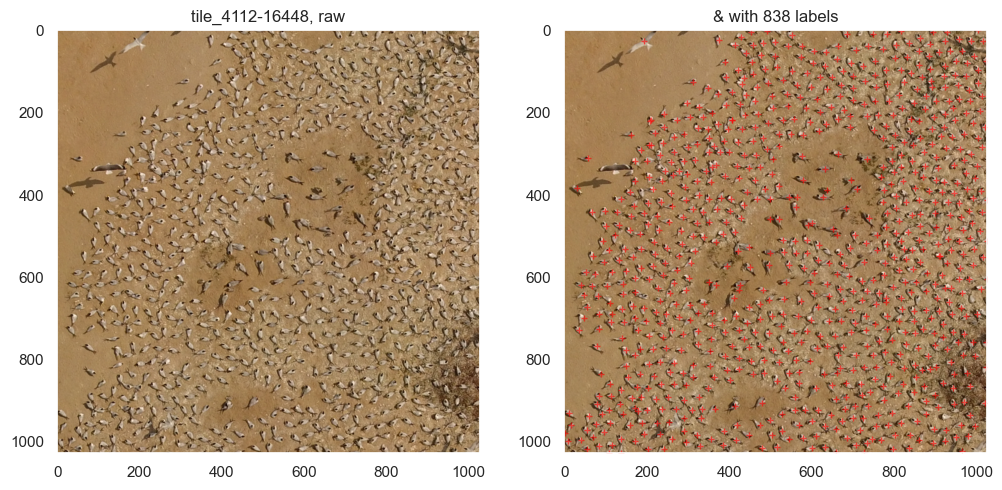

In [442]:
def plot_labelled_tile(tile, tiles, labels):
    birds = tiles[tile]['birds']

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

    xs = labels.iloc[birds]['X_tile'].astype(int)
    ys = labels.iloc[birds]['Y_tile'].astype(int)

    ax[0].imshow(skimage.io.imread('data/seabirds_split/'+tile+'.tif'))
    ax[0].set_title(f'{tile}, raw')
    ax[0].grid(False)
    
    ax[1].imshow(skimage.io.imread('data/seabirds_split/'+tile+'.tif'))
    ax[1].plot(xs, ys, linewidth=0, marker='+', markerfacecolor='none', markeredgecolor='red', markersize=5, markeredgewidth=1, alpha=0.6)
    ax[1].set_title(f'& with {len(tiles[tile]['birds'])} labels')
    ax[1].grid(False)

plot_labelled_tile('tile_4112-16448', tiles, lab)

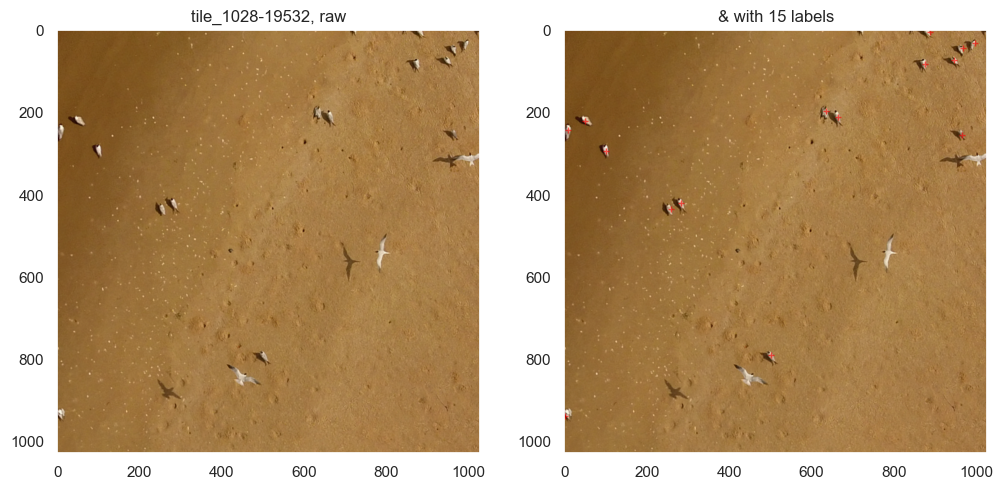

In [429]:
plot_labelled_tile('tile_1028-19532', tiles, lab)

### Discarding background

Now to drop any tiles that contain white background. Unfortunately, our data don't come with a pre-existing mask, so we'll have to do this manually.

In [335]:
def find_background(tiles, loud=False, plots=False):
    '''Given a list of tiles, check them for (white) background.
    
    if loud, print info for each hit.
    if plots, plot each hit for manual inspection.'''
    hits = []  # tiles which contain bg

    for i, tile in enumerate(tiles.keys()):
        fpath = 'data/seabirds_split/'+tile+'.tif'
        with rasterio.open(fpath) as src:
            rgb = np.stack((src.read(1), src.read(2), src.read(3)), axis=-1)
            white_mask = (rgb[:, :, 0] == 255) & (rgb[:, :, 1] == 255) & (rgb[:, :, 2] == 255)  # True where pixel is bg
            if True in white_mask:
                white = np.sum(white_mask)               
                tot = white_mask.shape[0] * white_mask.shape[1]
                per = white / tot * 100

                if loud:
                    print(f'{tile} contains background: {white} px of {tot} = {round(per,2)}%')
                
                hits.append(tile)

                if plots:
                    plt.figure()
                    plt.grid(False)
                    plt.imshow(white_mask, cmap='gray', vmin=0, vmax=1) # preserve cmap ordering to avoid inversion when plotting mixed T/F data
                    plt.title(f'{tile}')
                    plt.show()
                    
    print(f'found {len(hits)} tiles containing background, out of {len(tiles)} total ({round(len(hits)/len(tiles)*100,2)}%)')

    return hits

# find_background(tiles)

Looks like around 3/4 of our tiles contain background (any at all). Even assuming the original image is perfectly tiled (not exactly true) this is certainly an overestimate of how much of it is actually background, since we are counting those tiles which contain just a bit of bg too. To be more precise, we could do something like:

~~~python
# count % background in the whole image
with rasterio.open(impath) as src:
    rgb = np.stack((src.read(1), src.read(2), src.read(3)), axis=-1)
    white_mask = (rgb[:, :, 0] == 255) & (rgb[:, :, 1] == 255) & (rgb[:, :, 2] == 255)
    white = np.sum(white_mask)               
    tot = white_mask.shape[0] * white_mask.shape[1]
    per = white / tot * 100
    print(f'original image background: {white} px of {tot} = {round(per,2)}%')         
    plt.imshow(white_mask, cmap='gray')
    plt.grid(False)
~~~

Anyway, by dropping all of these tiles from our analysis, we are certainly being "wasteful" (in that with a more careful approach, we could salvage lots of valuable training data!), but for our purposes, quick and dirty is great.

To implement the exclusion, we can use set logic:

In [344]:
tiles_to_drop = find_background(tiles)

# thus the tiles we want are:
tiles_to_use = set(tiles.keys()) - set(tiles_to_drop)

found 574 tiles containing background, out of 783 total (73.31%)


Now we can simply to reference our `tiles` dictionary with this list of keys anytime we need to do a lookup.

**Note:** in the background, I also moved the excluded tiles to a new subdirectory make manual inspection simpler:

~~~python
f = [x+'.tif' for x in tiles_to_drop]
cmd = f'mv {' '.join(f)} -t excluded/'
print(cmd)
~~~

### Edge cases

The next challenge is contending with weird edge cases where bird(s) are truncated at the edges of a tile. Some thoughts:

1. We can try ignoring it for now, until we know whether it seems to negatively affect training in some substantial way.
2. We can try discarding the offending tiles by choosing some critical radius about our ground-truth labels, then checking each tile for whether the labels it contains are within that distance from the edges. My concern is that this might end up filtering a lot of tiles (even assuming I can get it to work well in the first place).

I can always come back and try to implement the second option (at least as a dry run) later, but for now let's just make a note and forge ahead.

### Terrain complexity

There is also the fact that different parts of this scene contain different kinds of terrain, from simple monochromatic sand to more heterogenous vegetation. _Prima facie_, the former seem easier to learn on. In the original paper, the authors partition the training phase such that those images are fed into the model first (to allow it to learn the "basics"), before then progressively exposing it to messier tiles (to learn more complicated detection); in their experience, doing so helped the model to avoid becoming overwhelmed early on. In particular,

>"We included background polygons (grey areas in Fig. 2) into the training process to teach the model what background clutter looks like. Background polygons are rasterized and rescaled to the same dimensions as the CNN predictions of 50 × 38 grid cells. We empirically found the model to be highly sensitive to the amount and complexity of background areas; exposing the model to all background polygons from the start generally resulted in a significant drop in bird recall. To mitigate this effect, we resorted to curriculum learning (Bengio et al., 2009), which has been shown to be beneficial for aerial wildlife detection tasks with deep learning (Kellenberger et al., 2018). In detail, we added all images containing the ‘easy’ background patches to the training set and trained the model for 10 epochs (i.e. 10 passes over all images). Afterwards, we also added the ‘hard’ background patches and trained the model for a total of 75 epochs. This ensured that the model can learn bird species appearances before potentially getting overwhelmed with the large background polygons and high complexity of them."

Trying something along these lines might be helpful, especially if (as above) training seems to suffer without it. Again, I will come back to this, but one possible implementation is just brute forcing it by manually inspecting the ~100 or so tiles that remain in my computer's GUI image viewer. Any other approach seems needlessly complicated.

### Final thoughts on the dataset before moving on

In the classroom/bootcamp setting, we would ideally start by giving an overview of the original dataset (and showing the steps that were taken to clean it up), but clearly there's limited value (and time) to have everyone repeat the process themselves! We should just provide a minimal working subset of the data for everyone to download and use directly. Hence, we can get right into...

## Designing our network

In Griffin's elephant notebook from CSHL, the dataset consisted of RGB pixels where "elephants" were uniquely colored and a single pixel in size. Here, our birds are multi-pixel objects...

Still, let's start with the bare minimum: a single sigmoid neuron that attempts to classify pixels as "bird" or "not bird".

An easy trick would be to massage our data until it exactly matches the format of Griffin's inputs --- then the rest will become totally plug-and-play. He creates a dataframe where every row is a pixel, and the columns are `label` (T/F), `R`, `G`, and `B`. We can recreate this for any given tile!

In [544]:
def index_to_rowcol(idx, array):
    '''Given the index for an element of a flattened array, compute the [row,col] indices of the original/reshaped array.
    Assumes row-major flattening (as is default for np.flatten()).'''
    # array dimensions
    rows, cols = array.shape[:2]

    # row index: floor of division by number of columns
    # i.e. how many full rows fit
    r = idx // cols

    # column index: remainder
    c = idx % cols

    return r,c

def rowcol_to_index(row, col, array):
    '''Inversely, given the [row,col] indices for an element of a 2D array, compute the new index in a flattened array.'''
    # array dimensions
    rows, cols = array.shape[:2]
    return row * cols + col

def make_df(tile, tiles, labels, normalize=True):
    '''Given a tile, produce a dataframe of Griffin's form.
    This may not be the best way to represent this data, but it will permit easy plug-and-play.'''

    im = skimage.io.imread(tiles[eg]['path'])

    if normalize:
        im = skimage.exposure.equalize_adapthist(im)
        # im = skimage.exposure.equalize_hist(im)


    rows, cols = im.shape[:2]

    # add the RGB values to a new dataframe
    r = pd.Series(im[:, :, 0].flatten())
    g = pd.Series(im[:, :, 1].flatten())
    b = pd.Series(im[:, :, 2].flatten())

    df = pd.DataFrame({'red':r,
                       'green':g,
                       'blue':b,
                       'label':0,
                       'label_index':None})

    # add label data to the corresponding pixels
    birds = tiles[tile]['birds']
    indices = labels.iloc[birds].index.values.astype(int)
    xs = labels.iloc[birds]['X_tile'].astype(int)
    ys = labels.iloc[birds]['Y_tile'].astype(int)
    
    # ugly np array comprehension to save ordered indices
    to_label = np.array([np.array([rowcol_to_index(y,x,im), z]) for x,y,z in zip(xs,ys,indices)])

    df.iloc[to_label[:,0], df.columns.get_loc('label')] = 1
    df.iloc[to_label[:,0], df.columns.get_loc('label_index')] = to_label[:,1]

    return df

eg = 'tile_1028-19532'

make_df(eg, tiles, lab)

,red,green,blue,label,label_index
0,0.356403,0.216941,0.065082,0,None
1,0.356403,0.220040,0.071281,0,None
2,0.346348,0.212670,0.066839,0,None
3,0.366457,0.227456,0.072660,0,None
4,0.366457,0.227456,0.072660,0,None
...,...,...,...,...,...
1056779,0.608191,0.447949,0.258572,0,None
1056780,0.578029,0.422948,0.243195,0,None
1056781,0.514680,0.368094,0.205221,0,None
1056782,0.568036,0.407731,0.230002,0,None


Let's double-check that the labeled indices indeed match our x,y values for ground-truth labels:

In [545]:
df = make_df(eg, tiles, lab)
df = df.loc[df['label']==1]
df

,red,green,blue,label,label_index
6028,0.778436,0.627771,0.539883,1,2384
33895,0.592771,0.496934,0.401096,1,2380
46200,0.898779,0.771554,0.697682,1,2381
75991,0.930299,0.869627,0.764463,1,2382
86201,0.946521,0.894382,0.782083,1,2383
203152,0.802924,0.724690,0.605281,1,2391
216545,0.649149,0.586089,0.489644,1,2390
226210,0.812485,0.702050,0.595559,1,1165
248785,0.819331,0.732253,0.653090,1,1164
262078,0.366334,0.303979,0.233830,1,2372


In [546]:
putative_labels = list(df.index.values)

for i in putative_labels:
    y, x = index_to_rowcol(i, skimage.io.imread(tiles[eg]['path']))
    print(x,y)

888 5
999 32
968 44
947 73
877 83
636 197
665 210
50 220
9 242
966 254
100 293
283 420
258 434
502 789
2 939


In [547]:
lab.iloc[tiles[eg]['birds']]

,label,unsure,X,Y,X_px,Y_px,tile,X_tile,Y_tile
1164,(unknown),True,11.007880,95.90422,1037,19774,tile_1028-19532,9,242
1165,(unknown),True,11.436886,96.13730,1078,19752,tile_1028-19532,50,220
1813,Royal tern,True,16.238199,90.09324,1530,20321,tile_1028-19532,502,789
2372,(unknown),True,21.154821,95.77219,1994,19786,tile_1028-19532,966,254
2380,Royal tern,True,21.508827,98.12380,2027,19564,tile_1028-19532,999,32
2381,Royal tern,True,21.180107,97.99737,1996,19576,tile_1028-19532,968,44
2382,Royal tern,True,20.960960,97.69394,1975,19605,tile_1028-19532,947,73
2383,Royal tern,True,20.210803,97.58436,1905,19615,tile_1028-19532,877,83
2384,Royal tern,True,20.337234,98.41881,1916,19537,tile_1028-19532,888,5
2390,Royal tern,True,17.964857,96.23685,1693,19742,tile_1028-19532,665,210


- Do we need to normalize the RGB values somehow?

In [548]:
training_data = make_df(eg, tiles, lab)
training_data

,red,green,blue,label,label_index
0,0.356403,0.216941,0.065082,0,None
1,0.356403,0.220040,0.071281,0,None
2,0.346348,0.212670,0.066839,0,None
3,0.366457,0.227456,0.072660,0,None
4,0.366457,0.227456,0.072660,0,None
...,...,...,...,...,...
1056779,0.608191,0.447949,0.258572,0,None
1056780,0.578029,0.422948,0.243195,0,None
1056781,0.514680,0.368094,0.205221,0,None
1056782,0.568036,0.407731,0.230002,0,None


# griffin's code

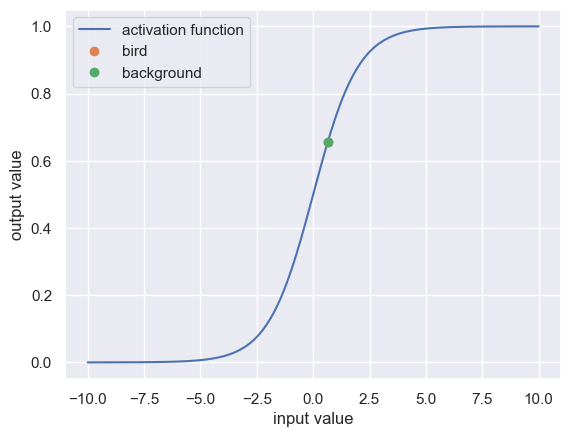

In [572]:
# Unpack the dataframe, transforming each column into an array
red_values = training_data['red'].values
green_values = training_data['green'].values
blue_values = training_data['blue'].values
label_values = training_data['label'].values

# Compute the total input for the first two points, which are elephant and background, respectively.
weight_red = 1
weight_green = 1
weight_blue = 1
elephant_input = weight_red * red_values[0] + weight_green * green_values[0] + weight_blue * blue_values[0]
background_input = weight_red * red_values[1] + weight_green * green_values[1] + weight_blue * blue_values[1]

# Compute the value of the output function
elephant_output = sigmoid(elephant_input)
background_output = sigmoid(background_input)

# Replot the sigmoid above
plt.plot(input_range, output_range, label='activation function')

# Plot these as points over the sigmoid curve above
plt.plot(elephant_input, elephant_output, 'o', label='bird')
plt.plot(background_input, background_output, 'o', label='background')

# Add axis labels
plt.xlabel('input value')
plt.ylabel('output value')

# Add a legend
plt.legend()

Text(0, 0.5, 'output value')

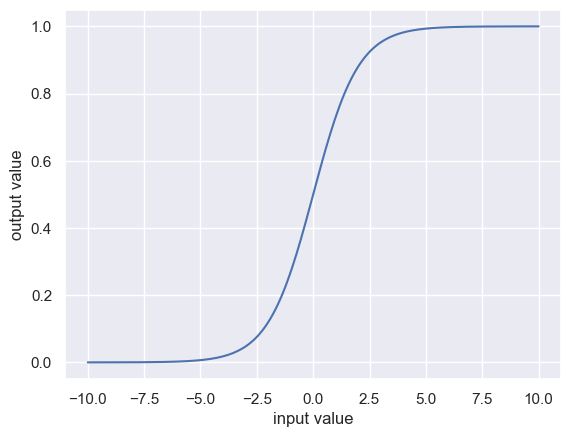

In [550]:
# Define a sigmoid activation function
def sigmoid(input):
  output = 1 / (1 + np.exp(-input))
  return output


# Set a range of input values and evaluate the sigmoid
input_range = np.linspace(-10, 10, 200)
output_range = sigmoid(input_range)

# Plot the sigmoidal output.
plt.plot(input_range, output_range)
plt.xlabel('input value')
plt.ylabel('output value')

In [573]:
# Write a function for evaluating the network and calculating the error
def assess_neuron(pixels, weights, truth):
  """
  Given inputs of red, green, and blue values and a set of weights,
  classify the pixel and then calcualte the sum squared error of each
  classification given the "truth".
  """
  # The pixels will be provided as a list in the order of R,G,B, as will the weights.
  # Using this, evaluate the input that will go to our sigmoid function
  input_value = weights[0] * pixels[0] + weights[1] * pixels[1] + weights[2] * pixels[2]
  output_value = sigmoid(input_value)

  # Compute the square differences from the truth, and sum over all pixels
  error = np.sum((output_value - truth)**2)

  # Return the output values and the errors.
  return output_value, error

In [574]:
# Define the initial weights
init_weights = np.array([1.0, 1.0, 1.0])

# Pack the red, green, and blue pixel arrays into a single pixel array
pixels = np.array([red_values, green_values, blue_values])

# Assess the current neuron
output, error = assess_neuron(pixels, init_weights, label_values)
print(f'Output values: {output}')
print(f'Evaluated error: {error}')

Output values: [0.65439749 0.65649719 0.65154959 ... 0.74800406 0.76954959 0.77385434]
Evaluated error: 623083.7505201622


In [575]:
# Convert the output to classifications
classification = np.round(output)

# Determine which of the classifications are not equal to the labels.
comparison = classification != label_values

# If the value of the above is 1.0 (True), then it's wrong.
# To determine the total number that's wrong, we just sum up the comparison
num_wrong = np.sum(comparison)

# Calculate the fraction we are getting wrong.
frac_wrong = num_wrong / len(training_data)
print(f'{100 * frac_wrong}% of pixels are misclassified')

99.99848597253555% of pixels are misclassified


In [576]:
# Define a function that computes the fraction that are misclassified
def misclassified(output, truth):
  """
  Compares the output to the true labels and returns the fraction that are
  misclassified.
  """

  # Convert the output to classifications
  classification = np.round(output)

  # Determine which of the classifications are not equal to the labels.
  comparison = classification != truth

  # If the value of the above is 1.0 (True), then it's wrong.
  # To determine the total number that's wrong, we just sum up the comparison
  num_wrong = np.sum(comparison)

  # Calculate the fraction we are getting wrong.
  frac_wrong = num_wrong / len(training_data)

  return frac_wrong

In [577]:
def learn(pixels, weights, truth, delta):
  """
  Tweak the weights by a value delta and choose new weights that reduce the error.
  """

  # First, let's assess the network given the  provided weights and inputs
  output, original_error = assess_neuron(pixels, weights, truth)

  # Make a new set of weights that we will update.
  new_weights = np.array([0.0, 0.0, 0.0])

  # Iterate through each weight
  for i in range(3):
    # Make a set of "test" weights
    test_weights = np.copy(weights)
    # Tweak the weight
    test_weights[i] = test_weights[i] + delta

    # Assess the neuron
    new_output, new_error = assess_neuron(pixels, test_weights, truth)
    # Determine if the error increased, decreased, or stayed the same
    if new_error < original_error:
      # Update the new weight with the old value + delta
      new_weights[i] = weights[i] + delta
    if new_error > original_error:
      # Update the new weight going in the other direction.
      new_weights[i] = weights[i] - delta
    if new_error == original_error:
      # Don't change the weight at all.
      new_weights[i] = weights[i]

  # Return the new weights
  return new_weights

In [578]:
# Choose a value for delta that is small
delta = 0.01

# Run one learning step
new_weights = learn(pixels, init_weights, label_values, delta)

# Print the two different weights
print(f'Initial weights: {init_weights}')
print(f'Learned weights: {new_weights}')

Initial weights: [1. 1. 1.]
Learned weights: [0.99 0.99 0.99]


In [579]:
# Run one learning step
new_weights_2 = learn(pixels, new_weights, label_values, delta)

# Print the two different weights
print(f'Initial weights: {new_weights}')
print(f'Learned weights: {new_weights_2}')

Initial weights: [0.99 0.99 0.99]
Learned weights: [0.98 0.98 0.98]


In [580]:
# Set the number of iterations
N_iterations = 500

# Reset the initial weights, so we can run this cell over and over
init_weights = np.array([1.0, 1.0, 1.0])

# Set up an empty array where we will store the fraction that are
# misclassified
frac_misclass = np.zeros(N_iterations)

# Set up an empty array where we will store the weights at each round
weights = np.zeros((N_iterations, 3)) # Each column will be the weight, and row the iter.

# Assess the initial misclassification
init_output, init_error = assess_neuron(pixels, init_weights, label_values)
init_misclass = misclassified(init_output, label_values)

# Store that in our vector
frac_misclass[0] = init_misclass

# Store our initial weights
weights[0] = init_weights

# Go through each iteration. We will use `tqdm` to show a little progress bar.
for i in tqdm.tqdm(range(1, N_iterations), desc='Learning elephants'):

  # Perform a learning step using the previous weights as the starting point
  new_weights = learn(pixels, weights[i-1], label_values, delta)
  weights[i] = new_weights

  # Compute the new misclassification fraction
  new_output, new_error = assess_neuron(pixels, new_weights, label_values)
  new_misclass = misclassified(new_output, label_values)
  frac_misclass[i] = new_misclass


Learning elephants: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:29<00:00, 16.96it/s]


Text(0, 0.5, 'misclassification %')

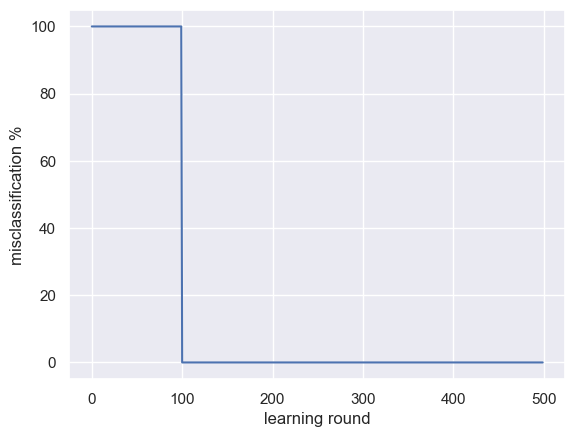

In [581]:
# Set up an a range of the learning steps
learning_rounds = np.arange(N_iterations)

# Plot the fraction misclassified as a percent
plt.plot(learning_rounds, frac_misclass * 100)

# Add axis labels
plt.xlabel('learning round')
plt.ylabel('misclassification %')

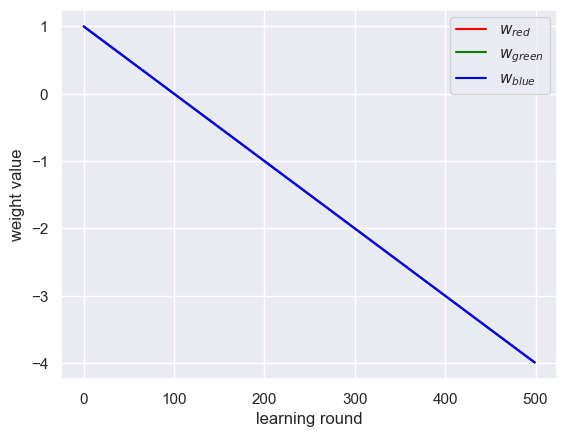

In [582]:
# Plot each weight as a function of the learning round. We will transpose the weights
# so the indexing is easier
transposed = weights.T
plt.plot(learning_rounds, transposed[0], label='$w_{red}$', color='red')
plt.plot(learning_rounds, transposed[1], label='$w_{green}$', color='green')
plt.plot(learning_rounds, transposed[2], label='$w_{blue}$', color='blue')

# Add labels
plt.xlabel('learning round')
plt.ylabel('weight value')
plt.legend()


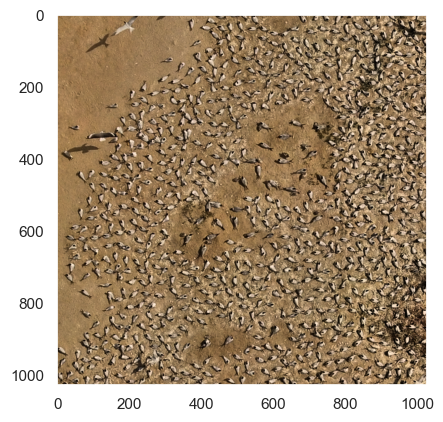

In [586]:
# Load a test image and display it.
test_image = skimage.io.imread(tiles['tile_4112-16448']['path'])
test_image = skimage.exposure.equalize_adapthist(test_image)

plt.imshow(test_image)
plt.grid(False)

In [587]:
# Get the dimensions of the image
dimension_x, dimension_y, n_channels = np.shape(test_image)

# Set up empty lists to store the x and y coordinates of the elephants
elephant_x = []
elephant_y = []

# Go through each X and Y coordinate in the image
for x in range(dimension_x):
  for y in range(dimension_y):
    # Get the pixel value at this X and Y
    pixel_value = test_image[y][x]

    # Compute the input using the latest trained weights
    input = np.sum(pixel_value * weights[-1])

    # Classify it using our sigmoid function
    output = sigmoid(input)

    # Determine if it's an elephant. If so, store the X and Y coordinate.
    if np.round(output) == 1:
      elephant_x.append(x)
      elephant_y.append(y)

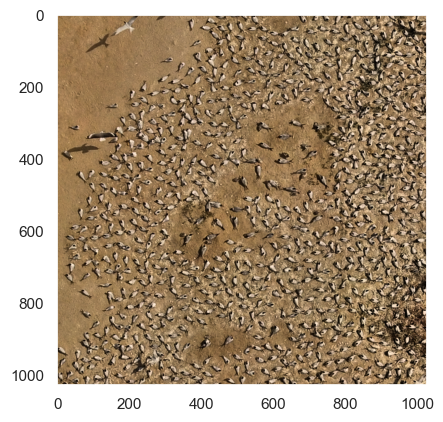

In [588]:
# Plot the test image
plt.imshow(test_image)

# Plot the elephant coordinates
plt.plot(elephant_x, elephant_y, 'o', markersize=15, markeredgecolor='red',
         markeredgewidth=3, markerfacecolor='none')
plt.grid(False)

# old ESA wildebeest stuff: need gdal etc

we download satellite images from the ESA's public archive of worldview data, manually selecting for those images from east Africa; while the selection is limited, they are sufficiently large and high-resolution that I am going to try subdividing and manually inspecting them to look for megafauna.

first, we need to read them and split them into training-sized grids.

I extract the zipped downloads with `unzip_raw.sh`, and find the paths to each .TIF image with `print_files.sh`, which yields `paths.txt`:

In [16]:
with open('paths.txt', 'r') as f:
    imgs = [Path(line.rstrip('\n')) for line in f]

print(imgs)

[PosixPath('data/ESA_satellite/WV2_OPER_WV1_4B__2A_20130624T082305_N01-580_E035-499_0001_v0100.SIP/13JUN24082305-M2AS-057204211010_01_P001.TIF'), PosixPath('data/ESA_satellite/WV2_OPER_WV1_4B__2A_20130624T082305_N01-580_E035-499_0001/13JUN24082305-M2AS-057204211010_01_P001.TIF'), PosixPath('data/ESA_satellite/WV2_OPER_WV1_4B__2A_20190130T081848_N01-580_E035-499_0001_v0100.SIP/19JAN30081848-M2AS-059053497010_01_P001.TIF'), PosixPath('data/ESA_satellite/WV2_OPER_WV1_4B__2A_20190130T081848_N01-580_E035-499_0001/19JAN30081848-M2AS-059053497010_01_P001.TIF'), PosixPath('data/ESA_satellite/WV2_OPER_WV1_8B__MP_20160316T075422_S02-342_E036-912_0001_v0100.SIP/16MAR16075422-M3DS-058186310010_01_P001.TIF'), PosixPath('data/ESA_satellite/WV2_OPER_WV1_8B__MP_20160316T075422_S02-342_E036-912_0001/16MAR16075422-M3DS-058186310010_01_P001.TIF'), PosixPath('data/ESA_satellite/WV2_OPER_WV1_8B__MP_20160316T075444_S02-341_E036-817_0001_v0100.SIP/16MAR16075444-M3DS-058186310010_01_P002.TIF'), PosixPath('dat

In [63]:
def divide_image(image_path, square_px=336):
    with Image.open(image_path) as im:
        width, height = im.size
        print(f"input img size: {width} x {height} px")
        
        output_dir = image_path / '..'
        output_dir = output_dir.resolve() / 'squares'
        os.makedirs(output_dir, exist_ok=True)
    
        # Calculate the number of squares horizontally and vertically
        num_cols = width // square_px
        num_rows = height // square_px

        print('generating', num_cols * num_rows, 'subimages')
    
        # Loop through the grid and save each subimage
        for row in range(num_rows):
            for col in range(num_cols):
                left = col * square_px
                upper = row * square_px
                right = left + square_px
                lower = upper + square_px
                box = (left, upper, right, lower)
                subimg = im.crop((left, upper, right, lower))
                subimg_path = output_dir / f"cell_{row}_{col}.TIF"
                subimg.save(subimg_path)
                print(f"saved subimage: {subimg_path}")

divide_image(imgs[0])

input img size: 6080 x 4240 px
generating 216 subimages


ValueError: unknown raw mode for given image mode

In [6]:
pdir = 'data/ESA_satellite/'
Image.MAX_IMAGE_PIXELS = None   # disables the decompression bomb warning
img = Image.open('/home/kian/projects/wildebeest/data/ESA_satellite/WV2_OPER_WV1_PAN_2A_20190130T081848_N01-580_E035-499_0001/19JAN30081848-P2AS-059053497010_01_P001.TIF')
width, height = img.size
print(f"Image size: {width} x {height} pixels")

# Calculate the number of squares horizontally and vertically
num_cols = width // 336
num_rows = height // 336

print(num_cols, num_rows)

Image size: 24320 x 16960 pixels
72 50


In [ ]:


# Define the path to your TIF image and the output directory
image_path = "path/to/your/image.tif"
output_dir = "path/to/output/directory"

# Divide the image and save the subimages
divide_image(image_path, output_dir)